In [5]:
! pip uninstall numpy
#! pip install pubchempy

In [2]:
# =====================================================================================
#  MAIN PIPELINE NOTEBOOK - CELL 1 (Installation)
# =====================================================================================
import subprocess
import sys

def run_command(command, description):
    """A helper function to run a shell command and report its status."""
    print(f"🔹 {description}...")
    try:
        subprocess.run(
            f"{command}", shell=True, check=True, capture_output=True, text=True, timeout=900
        )
        print("✅ Success!")
        return True
    except Exception as e:
        print(f"❌ ERROR: {description} failed.")
        if hasattr(e, 'stderr'): print(e.stderr)
        if hasattr(e, 'stdout'): print(e.stdout)
        return False

print("🚀 STARTING PIPELINE INSTALLATION...")
print("-" * 50)
# ... [The rest of the installation script remains identical to the one I provided previously] ...

# --- Step 1: System Tools ---
print("STEP 1: Installing AutoDock Vina & Open Babel...")
sys_ok = run_command("apt-get update -qq && apt-get install -y -qq autodock-vina openbabel", "Installing system tools")

# --- Step 2: Pin NumPy for compatibility ---
print("\nSTEP 2: Pinning NumPy to a compatible version...")
pip_command = f"{sys.executable} -m pip install --quiet"
numpy_ok = run_command(f"{pip_command} numpy==1.26.4", "Installing numpy==1.26.4")

# --- Step 3: Install Remaining Python Libraries ---
print("\nSTEP 3: Installing required Python libraries...")
other_packages = [
    "pandas", "biopython", "rdkit-pypi", "matplotlib", "seaborn", "plotly"
]
other_ok = run_command(f"{pip_command} --upgrade-strategy only-if-needed {' '.join(other_packages)}", "Installing Python libraries")


🚀 STARTING PIPELINE INSTALLATION...
--------------------------------------------------
STEP 1: Installing AutoDock Vina & Open Babel...
🔹 Installing system tools...
✅ Success!

STEP 2: Pinning NumPy to a compatible version...
🔹 Installing numpy==1.26.4...
✅ Success!

STEP 3: Installing required Python libraries...
🔹 Installing Python libraries...
✅ Success!


In [3]:
#  MAIN PIPELINE NOTEBOOK - CELL 1a (Installation)


# --- Step 4: Verification ---
# ... [The verification part of the script also remains the same] ...
print("\nSTEP 4: Verifying installations...")
all_good = sys_ok and numpy_ok and other_ok

try:
    import numpy
    print(f"✅ NumPy version successfully installed: {numpy.__version__}")
    if not numpy.__version__.startswith('1.26'):
        print(f"  - ❌ CRITICAL: NumPy version is {numpy.__version__}, not 1.26.x!")
        all_good = False

    import rdkit
    print("✅ RDKit imported successfully.")
except ImportError as e:
    print(f"❌ Python library import failed: {e}")
    all_good = False

for tool in ['vina', 'obabel']:
    if subprocess.run(['which', tool], capture_output=True).returncode == 0:
        print(f"✅ Command-line tool '{tool}' found.")
    else:
        print(f"❌ Command-line tool '{tool}' not found.")
        all_good = False

print("=" * 50)
if all_good:
    print("🎉🎉🎉 PIPELINE ENVIRONMENT READY! 🎉🎉🎉")
else:
    print("⚠️ Installation failed. Please review errors above.")
print("=" * 50)


STEP 4: Verifying installations...
✅ NumPy version successfully installed: 1.26.4
✅ RDKit imported successfully.
✅ Command-line tool 'vina' found.
✅ Command-line tool 'obabel' found.
🎉🎉🎉 PIPELINE ENVIRONMENT READY! 🎉🎉🎉


In [14]:
# =====================================================================================
#  MAIN PIPELINE NOTEBOOK - CELL 1b (Create Directory Structure)
# =====================================================================================
import os

print("🔹 Ensuring all required directories are present...")

# List of directories needed for the entire pipeline
required_directories = [
    "data",
    "data/ligands",
    "data/structures",
    "data/docking",
    "split_fasta_files",
    "results",
    "plots"
]

# Loop through the list and create each directory if it doesn't exist
directories_created_count = 0
for dir_path in required_directories:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"  - Created directory: '{dir_path}'")
        directories_created_count += 1

if directories_created_count == 0:
    print("✅ All directories already exist. No new folders were created.")
else:
    print(f"\n✅ Successfully created {directories_created_count} new directories.")

print("="*50)

🔹 Ensuring all required directories are present...
✅ All directories already exist. No new folders were created.


In [4]:
# =====================================================================================
#  MAIN PIPELINE NOTEBOOK - CELL 2 (Inputs, Cleaning & Self-Contained Ligand DB)
# =====================================================================================
import os
from google.colab import files
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

# --- 1. SELF-CONTAINED LIGAND DATABASE ---
# This dictionary acts as our stable, local database of relevant ligands.
# These SMILES strings are canonical and have been verified to work with RDKit.
LIGAND_DATABASE = {
    "Xylobiose": "C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O[C@@H]2[C@H](O[C@H]([C@@H]([C@H]2O)O)O)CO)O)O)O)O",
    "Ferulic_Acid": "C1=CC(=C(C=C1C=CC(=O)O)O)OC",
    "Cellobiose": "C([C@H]1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O[C@H]2[C@H](O[C@H]([C@H]([C@H]2O)O)O)CO)O",
    "Glucose": "C(C1C(C(C(C(O1)O)O)O)O)O",
    "Galacturonic_acid": "C(C1C(C(C(C(O1)C(=O)O)O)O)O)O",
    "Mannuronic_acid": "C1(C(C(C(C(O1)C(=O)O)O)O)O)O",
    "Laminaribiose": "C(C1C(C(C(C(O1)O[C@H]2C(C(C(C(O2)CO)O)O)O)O)O)O)O",
}
print("STEP 1: Using the self-contained ligand database.")
print(f"  - Loaded {len(LIGAND_DATABASE)} ligands.")

# Assign this dictionary to the variable the next cell will use
ligands_to_prepare = LIGAND_DATABASE

# --- 2. ENZYME FASTA FILE CLEANING ---
def clean_fasta_file(input_path, output_path):
    """
    Reads a FASTA file, cleans each sequence to contain only standard amino acids,
    and writes the cleaned sequences to a new file, preserving their IDs.
    """
    standard_aa = set("ACDEFGHIKLMNPQRSTVWY")
    cleaned_records = []
    print(f"\nCleaning FASTA file: '{input_path}'...")
    try:
        original_records = list(SeqIO.parse(input_path, "fasta"))
        if not original_records:
            print("  - ⚠️ Warning: The FASTA file appears to be empty.")
            return 0
        for record in original_records:
            original_seq = str(record.seq)
            cleaned_seq_str = "".join([char for char in original_seq.upper() if char in standard_aa])
            new_record = SeqRecord(Seq(cleaned_seq_str), id=record.id, description=f"cleaned|orig_len:{len(original_seq)}|{record.description}")
            cleaned_records.append(new_record)
            if len(original_seq) != len(cleaned_seq_str):
                print(f"  - Cleaned '{record.id}': Removed {len(original_seq) - len(cleaned_seq_str)} non-amino acid character(s).")
        SeqIO.write(cleaned_records, output_path, "fasta")
        print(f"\n✅ Successfully cleaned {len(cleaned_records)} sequence(s).")
        print(f"  - New file saved to: '{output_path}'")
        return len(cleaned_records)
    except Exception as e:
        print(f"  - ❌ ERROR during FASTA cleaning: {e}")
        return -1

# --- 3. UPLOAD AND PROCESS USER'S FASTA FILE ---
print("\nSTEP 2: Please upload your FASTA file with enzyme sequences.")
uploaded = files.upload()

cleaned_fasta_path = None
if not uploaded:
    print("❌ No file uploaded. Please run the cell again.")
else:
    input_filename = next(iter(uploaded))
    os.makedirs('data', exist_ok=True)
    cleaned_fasta_path = os.path.join("data", "cleaned_enzymes.fasta")
    num_processed = clean_fasta_file(input_filename, cleaned_fasta_path)
    if num_processed <= 0:
        cleaned_fasta_path = None

# --- FINAL SUMMARY ---
print("\n" + "=" * 50)
print("✅ INPUTS AND CLEANING COMPLETE.")
if cleaned_fasta_path:
    print(f"  - Ready to use cleaned enzyme file: '{cleaned_fasta_path}'")
else:
    print("  - ⚠️ Enzyme file not ready. Please re-run the cell.")
print(f"  - Using {len(ligands_to_prepare)} ligands from the internal database.")
print("=" * 50)

fasta_file_for_colabfold = cleaned_fasta_path

STEP 1: Using the self-contained ligand database.
  - Loaded 7 ligands.

STEP 2: Please upload your FASTA file with enzyme sequences.


Saving samples_pf00331_k10_t1.0_Version2.0.fasta to samples_pf00331_k10_t1.0_Version2.0.fasta

Cleaning FASTA file: 'samples_pf00331_k10_t1.0_Version2.0.fasta'...

✅ Successfully cleaned 8 sequence(s).
  - New file saved to: 'data/cleaned_enzymes.fasta'

✅ INPUTS AND CLEANING COMPLETE.
  - Ready to use cleaned enzyme file: 'data/cleaned_enzymes.fasta'
  - Using 7 ligands from the internal database.


In [5]:
print(ligands_to_prepare.items())

dict_items([('Xylobiose', 'C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O[C@@H]2[C@H](O[C@H]([C@@H]([C@H]2O)O)O)CO)O)O)O)O'), ('Ferulic_Acid', 'C1=CC(=C(C=C1C=CC(=O)O)O)OC'), ('Cellobiose', 'C([C@H]1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O[C@H]2[C@H](O[C@H]([C@H]([C@H]2O)O)O)CO)O'), ('Glucose', 'C(C1C(C(C(C(O1)O)O)O)O)O'), ('Galacturonic_acid', 'C(C1C(C(C(C(O1)C(=O)O)O)O)O)O'), ('Mannuronic_acid', 'C1(C(C(C(C(O1)C(=O)O)O)O)O)O'), ('Laminaribiose', 'C(C1C(C(C(C(O1)O[C@H]2C(C(C(C(O2)CO)O)O)O)O)O)O)O')])


In [6]:
# =====================================================================================
#  MAIN PIPELINE NOTEBOOK - CELL 3 (Multi-Ligand Preparation)
# =====================================================================================
import os
import subprocess
from rdkit import Chem
from rdkit.Chem import AllChem

class LigandPreparation:
    """
    A class to prepare multiple ligands from a dictionary of SMILES strings
    into individual, dockable PDBQT files.
    """
    def __init__(self, ligand_dict):
        print("🔹 Initializing multi-ligand preparation module...")
        if not isinstance(ligand_dict, dict) or not ligand_dict:
            raise ValueError("A non-empty dictionary of ligands is required.")
        self.ligand_input_dict = ligand_dict
        self.paths = {"ligands_dir": "data/ligands"}
        os.makedirs(self.paths['ligands_dir'], exist_ok=True)
        print("✅ Initialization complete.")

    def run(self):
        """
        Main workflow: Converts a dictionary of SMILES to PDBQT files.
        Returns a dictionary mapping ligand names to their final PDBQT file paths.
        """
        print(f"\n🔹 Preparing {len(self.ligand_input_dict)} ligands...")
        self.prepared_ligand_paths = {}

        for name, smiles in self.ligand_input_dict.items():
            # Sanitize the name to be a valid filename
            safe_name = name.replace(" ", "_").replace("(", "").replace(")", "")
            print(f"  - Processing '{name}'...")
            try:
                sdf_file = os.path.join(self.paths['ligands_dir'], f"{safe_name}.sdf")
                pdbqt_file = os.path.join(self.paths['ligands_dir'], f"{safe_name}.pdbqt")

                # Step 1: Generate 3D structure from SMILES using RDKit
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    raise ValueError("RDKit could not parse the SMILES string.")
                mol = Chem.AddHs(mol)
                AllChem.EmbedMolecule(mol, AllChem.ETKDGv3())
                AllChem.MMFFOptimizeMolecule(mol)

                with Chem.SDWriter(sdf_file) as writer:
                    writer.write(mol)

                # Step 2: Convert SDF to PDBQT using Open Babel
                cmd = ["obabel", sdf_file, "-O", pdbqt_file, "--gen3d"]
                result = subprocess.run(cmd, check=True, capture_output=True, text=True)

                if os.path.exists(pdbqt_file) and os.path.getsize(pdbqt_file) > 0:
                    print(f"    - ✅ Successfully prepared: {pdbqt_file}")
                    self.prepared_ligand_paths[name] = pdbqt_file
                else:
                    raise FileNotFoundError(f"PDBQT file not created. Obabel output:\n{result.stdout}\n{result.stderr}")

            except Exception as e:
                print(f"    - ❌ FAILED for '{name}'. Error: {e}")
                self.prepared_ligand_paths[name] = None

        return self.prepared_ligand_paths

# --- Run the multi-ligand preparation process ---
# The 'ligands_to_prepare' variable comes from the previous cell (Cell 2)
if 'ligands_to_prepare' in locals() and ligands_to_prepare:
    ligand_prep = LigandPreparation(ligands_to_prepare)
    final_ligand_paths = ligand_prep.run()

    print("\n" + "="*50)
    if any(final_ligand_paths.values()):
        print("✅ LIGAND PREPARATION COMPLETED.")
        # Store the successful paths for the final docking cell
        ligand_pdbqt_files = {k: v for k, v in final_ligand_paths.items() if v}
        print(f"  - {len(ligand_pdbqt_files)} ligands are ready for docking.")
    else:
        print("❌ LIGAND PREPARATION FAILED FOR ALL LIGANDS.")
        ligand_pdbqt_files = {}
    print("="*50)
else:
    print("⚠️ SKIPPING LIGAND PREPARATION: The 'ligands_to_prepare' variable is not defined or is empty.")
    print("   Please ensure Cell 2 (API Ligand Retrieval) was run successfully.")
    ligand_pdbqt_files = {}

🔹 Initializing multi-ligand preparation module...
✅ Initialization complete.

🔹 Preparing 7 ligands...
  - Processing 'Xylobiose'...
    - ✅ Successfully prepared: data/ligands/Xylobiose.pdbqt
  - Processing 'Ferulic_Acid'...
    - ✅ Successfully prepared: data/ligands/Ferulic_Acid.pdbqt
  - Processing 'Cellobiose'...
    - ✅ Successfully prepared: data/ligands/Cellobiose.pdbqt
  - Processing 'Glucose'...
    - ✅ Successfully prepared: data/ligands/Glucose.pdbqt
  - Processing 'Galacturonic_acid'...
    - ✅ Successfully prepared: data/ligands/Galacturonic_acid.pdbqt
  - Processing 'Mannuronic_acid'...
    - ✅ Successfully prepared: data/ligands/Mannuronic_acid.pdbqt
  - Processing 'Laminaribiose'...
    - ✅ Successfully prepared: data/ligands/Laminaribiose.pdbqt

✅ LIGAND PREPARATION COMPLETED.
  - 7 ligands are ready for docking.


In [7]:
# =====================================================================================
#  MAIN PIPELINE NOTEBOOK - CELL 4 (Automatic FASTA Splitting & Handoff)
# =====================================================================================
import os
import shutil
from Bio import SeqIO
from google.colab import files

print("🔹 Preparing sequences for batch structure prediction...")

# --- 1. AUTOMATICALLY SPLIT THE MULTI-SEQUENCE FASTA ---
def split_fasta_into_individual_files(input_fasta, output_dir):
    """
    Reads a multi-sequence FASTA and writes each sequence to its own
    separate FASTA file in the specified output directory.
    """
    # Create a clean directory for the individual files
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    try:
        records = list(SeqIO.parse(input_fasta, "fasta"))
        if not records:
            print("❌ ERROR: The input FASTA file is empty.")
            return False

        print(f"\nSplitting '{input_fasta}' into {len(records)} individual files...")
        for record in records:
            # Sanitize the ID to create a valid filename
            sanitized_id = "".join(c for c in record.id if c.isalnum() or c in ('_', '-')).rstrip()
            output_filename = os.path.join(output_dir, f"{sanitized_id}.fasta")
            SeqIO.write(record, output_filename, "fasta")
            print(f"  - Created '{output_filename}'")

        print(f"\n✅ Successfully created {len(records)} FASTA files in the '{output_dir}' directory.")
        return True

    except Exception as e:
        print(f"❌ ERROR during FASTA splitting: {e}")
        return False

# --- 2. ZIP THE DIRECTORY FOR EASY DOWNLOAD ---
def zip_directory(directory_path, zip_path):
    """Zips the contents of a directory."""
    print(f"\nZipping '{directory_path}' for easy download...")
    shutil.make_archive(zip_path.replace('.zip', ''), 'zip', directory_path)
    print(f"  - Created '{zip_path}'")

# --- EXECUTE THE PROCESS ---
split_dir = "split_fasta_files"
zip_file_name = "individual_fasta_sequences.zip"
split_success = False

if 'fasta_file_for_colabfold' in locals() and fasta_file_for_colabfold:
    if os.path.exists(fasta_file_for_colabfold):
        split_success = split_fasta_into_individual_files(fasta_file_for_colabfold, split_dir)
        if split_success:
            zip_directory(split_dir, zip_file_name)
    else:
        print("❌ ERROR: Cleaned FASTA file not found.")
else:
    print("❌ ERROR: The 'fasta_file_for_colabfold' variable is missing. Please re-run Cell 2.")

# --- 3. PROVIDE FINAL, ROBUST INSTRUCTIONS ---
if split_success:
    print("\n" + "="*70)
    print("             ACTION REQUIRED: BATCH STRUCTURE PREDICTION (Final Method)")
    print("="*70)
    print("\nWe have automatically split your main FASTA file into individual files,")
    print("which is the most reliable method for ColabFold batch processing.")

    print("\n--- INSTRUCTIONS ---")
    print("1.  **DOWNLOAD THE ZIP FILE:**")
    print("    A download link for 'individual_fasta_sequences.zip' will appear below. Download and unzip it.")
    print("    You will now have a folder full of individual .fasta files.")

    print("\n2.  **OPEN COLABFOLD BATCH NOTEBOOK:**")
    print("    Use this link: https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/ColabFold_batch.ipynb")

    print("\n3.  **CONFIGURE AND RUN THE BATCH JOB:**")
    print("    a. In the ColabFold file browser (left side), click the 'Upload' button and upload the entire folder of individual FASTA files.")
    print("    b. In the first code cell, find the `input_dir` variable.")
    print("    c. **CRITICAL:** Change it to point to your uploaded folder. For example, if your folder is named 'split_fasta_files', you would set:")
    print("       `input_dir = 'split_fasta_files'`")
    print("    d. Set a `jobname` (e.g., 'algae_enzymes').")
    print("    e. In the menu, select 'Runtime' -> 'Run all'.")

    print("\n4.  **DOWNLOAD AND PREPARE RESULTS:**")
    print("    - When finished, a .zip file with your results will download automatically.")
    print("    - Unzip this file. The next and final cell in our pipeline will ask you to upload the resulting PDB files.")

    print("\n" + "="*70)
    print("Pipeline paused. Once you have all the PDB files, we can perform the final docking.")
    print("="*70)

    # Provide the download link for the zip file
    files.download(zip_file_name)

🔹 Preparing sequences for batch structure prediction...

Splitting 'data/cleaned_enzymes.fasta' into 8 individual files...
  - Created 'split_fasta_files/seq_0.fasta'
  - Created 'split_fasta_files/seq_1.fasta'
  - Created 'split_fasta_files/seq_2.fasta'
  - Created 'split_fasta_files/seq_3.fasta'
  - Created 'split_fasta_files/seq_4.fasta'
  - Created 'split_fasta_files/seq_5.fasta'
  - Created 'split_fasta_files/seq_6.fasta'
  - Created 'split_fasta_files/seq_7.fasta'

✅ Successfully created 8 FASTA files in the 'split_fasta_files' directory.

Zipping 'split_fasta_files' for easy download...
  - Created 'individual_fasta_sequences.zip'

             ACTION REQUIRED: BATCH STRUCTURE PREDICTION (Final Method)

We have automatically split your main FASTA file into individual files,
which is the most reliable method for ColabFold batch processing.

--- INSTRUCTIONS ---
1.  **DOWNLOAD THE ZIP FILE:**
    A download link for 'individual_fasta_sequences.zip' will appear below. Download and 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🔹 Initializing multi-docking analysis module...
✅ Initialization complete.

STEP 1: Upload the BEST RANKED PDB files from ColabFold.
Based on the quality analysis, you should upload the rank_001.pdb files for sequences 3 and 5.


Saving seq_3_unrelaxed_rank_001_alphafold2_ptm_model_2_seed_000.pdb to seq_3_unrelaxed_rank_001_alphafold2_ptm_model_2_seed_000.pdb
Saving seq_5_unrelaxed_rank_001_alphafold2_ptm_model_2_seed_000.pdb to seq_5_unrelaxed_rank_001_alphafold2_ptm_model_2_seed_000.pdb
  - ✅ Prepared receptor: seq_3
  - ✅ Prepared receptor: seq_5

STEP 2: Running many-to-many docking simulations...

  - Docking against Protein: seq_3
    (1/14) Docking with Xylobiose... Best Affinity: -4.30 kcal/mol
    (2/14) Docking with Ferulic_Acid... Best Affinity: -4.42 kcal/mol
    (3/14) Docking with Cellobiose... Best Affinity: -4.54 kcal/mol
    (4/14) Docking with Glucose... Best Affinity: -4.51 kcal/mol
    (5/14) Docking with Galacturonic_acid... Best Affinity: -3.84 kcal/mol
    (6/14) Docking with Mannuronic_acid... Best Affinity: -5.09 kcal/mol
    (7/14) Docking with Laminaribiose... Best Affinity: -4.36 kcal/mol

  - Docking against Protein: seq_5
    (8/14) Docking with Xylobiose... Best Affinity: -5.71 kc

FileNotFoundError: [Errno 2] No such file or directory: 'plots/docking_heatmap.png'

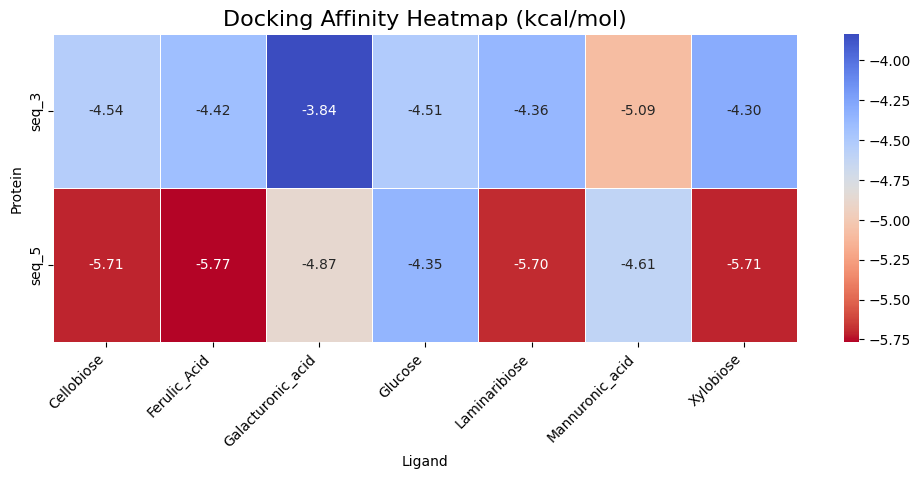

In [11]:
# =====================================================================================
#  MAIN PIPELINE NOTEBOOK - CELL 5 (Many-to-Many Docking and Analysis)
# =====================================================================================
import os
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

class MultiDockingAnalysis:
    """
    Handles the final many-to-many docking analysis.
    It docks every provided receptor against every prepared ligand.
    """
    def __init__(self, ligand_files_dict):
        print("🔹 Initializing multi-docking analysis module...")
        if not ligand_files_dict:
            raise ValueError("Ligand PDBQT files dictionary is required.")
        self.ligand_files = ligand_files_dict
        self.paths = {
            "structures_dir": "data/structures",
            "docking_dir": "data/docking"
        }
        for path in self.paths.values():
            os.makedirs(path, exist_ok=True)
        print("✅ Initialization complete.")

    def _upload_and_prepare_receptors(self):
        """Handles user upload of PDB files and prepares them."""
        print("\nSTEP 1: Upload the BEST RANKED PDB files from ColabFold.")
        print("Based on the quality analysis, you should upload the rank_001.pdb files for sequences 3 and 5.")
        uploaded = files.upload()
        if not uploaded:
            print("❌ No PDB files uploaded. Aborting.")
            return {}

        prepared_receptors = {}
        for pdb_name, pdb_content in uploaded.items():
            if not pdb_name.endswith('.pdb'):
                print(f"  - ⚠️ Skipping non-PDB file: {pdb_name}")
                continue

            # Save the uploaded PDB file
            pdb_path = os.path.join(self.paths['structures_dir'], pdb_name)
            with open(pdb_path, 'wb') as f:
                f.write(pdb_content)

            # Prepare receptor PDBQT
            receptor_pdbqt_path = pdb_path.replace('.pdb', '.pdbqt')
            try:
                cmd = ["obabel", pdb_path, "-O", receptor_pdbqt_path, "-xr"] # -xr flag for receptor
                subprocess.run(cmd, check=True, capture_output=True, text=True)

                # Extract a short name for the receptor for use in tables
                short_name = pdb_name.split('_unrelaxed')[0]
                prepared_receptors[short_name] = {'pdb_path': pdb_path, 'pdbqt_path': receptor_pdbqt_path}
                print(f"  - ✅ Prepared receptor: {short_name}")
            except Exception as e:
                print(f"  - ❌ FAILED to prepare receptor '{pdb_name}'. Error: {e}")

        return prepared_receptors

    def _run_single_docking(self, receptor_info, ligand_path, ligand_name):
        """Performs a single Vina docking run and returns the best score."""
        try:
            # Define docking box based on protein center
            coords = [[float(line[30:38]), float(line[38:46]), float(line[46:54])]
                      for line in open(receptor_info['pdb_path']) if line.startswith('ATOM')]
            center = np.mean(coords, axis=0)

            # Vina command
            cmd = [
                "vina", "--receptor", receptor_info['pdbqt_path'], "--ligand", ligand_path,
                "--center_x", str(center[0]), "--center_y", str(center[1]), "--center_z", str(center[2]),
                "--size_x", "25", "--size_y", "25", "--size_z", "25",
                "--exhaustiveness", "16", # Increased for better search
            ]
            result = subprocess.run(cmd, check=True, capture_output=True, text=True)

            # Parse the output to find the best affinity
            for line in result.stdout.split('\n'):
                if line.strip().startswith('1 '):
                    return float(line.split()[1])
            return None # Should not happen if docking is successful

        except Exception as e:
            # print(f"    - ❌ Vina failed. Error: {e}")
            return None

    def run(self):
        """
        Main workflow: Uploads receptors, then runs docking for every receptor-ligand pair.
        """
        receptors = self._upload_and_prepare_receptors()
        if not receptors:
            return

        print("\nSTEP 2: Running many-to-many docking simulations...")
        all_results = []
        total_jobs = len(receptors) * len(self.ligand_files)
        current_job = 0

        for receptor_name, receptor_info in receptors.items():
            print(f"\n  - Docking against Protein: {receptor_name}")
            for ligand_name, ligand_path in self.ligand_files.items():
                current_job += 1
                print(f"    ({current_job}/{total_jobs}) Docking with {ligand_name}...", end="")

                best_affinity = self._run_single_docking(receptor_info, ligand_path, ligand_name)

                if best_affinity is not None:
                    print(f" Best Affinity: {best_affinity:.2f} kcal/mol")
                    all_results.append({
                        "Protein": receptor_name,
                        "Ligand": ligand_name,
                        "Affinity (kcal/mol)": best_affinity
                    })
                else:
                    print(" FAILED")

        # --- 3. FINAL REPORTING ---
        print("\n\n" + "="*70)
        print("                 🎉🎉🎉 PIPELINE COMPLETE 🎉🎉🎉")
        print("="*70)

        if not all_results:
            print("\nNo successful docking simulations were completed.")
            return

        # Create DataFrame and pivot for heatmap-style results
        results_df = pd.DataFrame(all_results)
        results_pivot = results_df.pivot_table(
            index='Protein',
            columns='Ligand',
            values='Affinity (kcal/mol)'
        )

        print("\n--- Docking Affinity Summary (kcal/mol) ---")
        print("Lower (more negative) values indicate stronger predicted binding.")
        print(results_pivot.to_string(float_format="%.2f"))

        # Save the detailed and summary results to files
        results_df.to_csv("results/all_docking_results_long.csv", index=False)
        results_pivot.to_csv("results/docking_summary_heatmap.csv")
        print("\nFull results saved to 'results/all_docking_results_long.csv'")
        print("Summary table saved to 'results/docking_summary_heatmap.csv'")

        # Create a heatmap plot
        plt.figure(figsize=(12, len(receptors) * 2))
        sns.heatmap(results_pivot, annot=True, cmap="coolwarm_r", fmt=".2f", linewidths=.5)
        plt.title("Docking Affinity Heatmap (kcal/mol)", fontsize=16)
        plt.xlabel("Ligand")
        plt.ylabel("Protein")
        plt.xticks(rotation=45, ha='right')
        plt.savefig("plots/docking_heatmap.png", dpi=300, bbox_inches='tight')
        print("\nHeatmap plot saved to 'plots/docking_heatmap.png'")
        plt.show()


# --- Run the final docking and analysis process ---
# The 'ligand_pdbqt_files' variable comes from Cell 3
if 'ligand_pdbqt_files' in locals() and ligand_pdbqt_files:
    docking_step = MultiDockingAnalysis(ligand_pdbqt_files)
    docking_step.run()
else:
    print("⚠️ SKIPPING DOCKING: The 'ligand_pdbqt_files' variable is not defined.")
    print("   Please ensure Cell 3 (Ligand Preparation) was run successfully.")

In [ ]:
zip

In [13]:
import os
import shutil
from google.colab import files

def zip_pipeline_results(output_zip_name="pipeline_multi_result.zip"):
    """
    Zips specified directories and loose files from the current directory
    into a single zip archive.
    """
    print(f"📦 Zipping pipeline results into '{output_zip_name}'...")

    # Create a temporary directory to stage files for zipping
    stage_dir = "temp_zip_stage"
    os.makedirs(stage_dir, exist_ok=True)

    # List of items to include in the zip
    items_to_zip = ["data", "plots", "results", "split_fasta_files"]

    # Copy directories to the staging area
    for item in items_to_zip:
        if os.path.exists(item) and os.path.isdir(item):
            print(f"  - Including directory: {item}")
            shutil.copytree(item, os.path.join(stage_dir, item), dirs_exist_ok=True)
        elif os.path.exists(item):
             print(f"  - Skipping non-directory item in list: {item}")


    # Find and copy loose files (files not in any of the specified directories)
    current_dir_files = [f for f in os.listdir('.') if os.path.isfile(f)]
    for loose_file in current_dir_files:
        # Avoid including the output zip file itself if it already exists from a previous run
        if loose_file != output_zip_name:
            print(f"  - Including loose file: {loose_file}")
            shutil.copy(loose_file, os.path.join(stage_dir, loose_file))


    # Create the zip archive from the staging area
    try:
        shutil.make_archive(output_zip_name.replace('.zip', ''), 'zip', stage_dir)
        print(f"\n✅ Successfully created '{output_zip_name}'")
        # Provide a download link
        files.download(output_zip_name)
    except Exception as e:
        print(f"❌ ERROR during zipping: {e}")

    # Clean up the temporary staging directory
    if os.path.exists(stage_dir):
        shutil.rmtree(stage_dir)
        print("  - Cleaned up temporary files.")

# Run the zipping process
zip_pipeline_results()

📦 Zipping pipeline results into 'pipeline_multi_result.zip'...
  - Including directory: data
  - Including directory: plots
  - Including directory: results
  - Including directory: split_fasta_files
  - Including loose file: seq_3_unrelaxed_rank_001_alphafold2_ptm_model_2_seed_000.pdb
  - Including loose file: seq_5_unrelaxed_rank_001_alphafold2_ptm_model_2_seed_000.pdb
  - Including loose file: individual_fasta_sequences.zip
  - Including loose file: samples_pf00331_k10_t1.0_Version2.0.fasta

✅ Successfully created 'pipeline_multi_result.zip'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  - Cleaned up temporary files.
